In [1]:
import numpy as np
import pandas as pd

In [167]:
data = pd.read_csv('./data/retail_train.csv')

In [168]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


### Train-test split

In [169]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [170]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

### weighted_random_recommendation

In [171]:
sales_sum = data_train.groupby(['item_id'])['sales_value'].sum()

In [172]:
(sales_sum < 1).value_counts()

False    83450
True      3415
Name: sales_value, dtype: int64

In [173]:
(sales_sum == 0).value_counts()

False    86456
True       409
Name: sales_value, dtype: int64

Присутствует 3415 товаров с суммой покупок меньше 1, из них 409 товаров с суммой равной 0. Чтобы корректно посчитать веса (log(sales_sum)), прибавим единицу ко всем значениям. 

Затем нормируем их.

In [213]:
items_weights = data.groupby(['item_id'])['sales_value'].sum().reset_index()
items_weights.rename(columns={'sales_value': 'weight'}, inplace=True)

items_weights['weight'] = np.log(items_weights['weight'] + 1)
items_weights['weight'] = items_weights['weight'] / items_weights['weight'].sum()

items_weights.sort_values(by='weight', ascending=False).head()

,item_id,weight
56233,6534178,0.000053
56193,6533889,0.000043
29195,1029743,0.000043
56228,6534166,0.000042
35054,1082185,0.000041


In [216]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    items = items_weights['item_id'].values
    weight = items_weights['weight'].values
    
    recs = np.random.choice(items, size=n, p=weight)
    
    return recs.tolist()

In [217]:
weighted_random_recommendation(items_weights, n=5)

[832607, 989662, 12384806, 7168439, 1049391]

### Можно ли улучшить бейзлайны, если считать их на топ-5000 товарах?

In [91]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [92]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    #print(recs)
    return recs.tolist()

In [93]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    items = items_weights['item_id'].values
    weight = items_weights['weight'].values
    
    recs = np.random.choice(items, size=n, p=weight)
    
    return recs.tolist()

Зададим функцию для получения весов.

In [176]:
def get_weights(data):
    '''Получение весов для айтемов
    
    Input
    -----
    data: pd.DataFrame
        
    '''
    items_weights = data.groupby(['item_id'])['sales_value'].sum().reset_index()
    items_weights.rename(columns={'sales_value': 'weight'}, inplace=True)
    
    items_weights['weight'] = np.log(items_weights['weight'] + 1)
    items_weights['weight'] = items_weights['weight'] / items_weights['weight'].sum()
    
    return items_weights

In [178]:
get_weights(data_train).head()

,item_id,weight
0,25671,0.000013
1,26081,0.000003
2,26093,0.000004
3,26190,0.000004
4,26355,0.000005


In [179]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [137]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [184]:
# все товары
all_items = data_train.item_id.unique()
# топ-5000 товаров
top5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.to_list()

In [185]:
%%time

result['all_items_random'] = result['user_id'].apply(lambda x: random_recommendation(all_items, n=5))
result['top5000_random'] = result['user_id'].apply(lambda x: random_recommendation(top5000, n=5))

CPU times: user 4.22 s, sys: 0 ns, total: 4.22 s
Wall time: 4.22 s


In [186]:
%%time

all_items_popular = popularity_recommendation(data_train, n=5)
top5000_popular = popularity_recommendation(data_train[data_train['item_id'].isin(top5000)], n=5)

result['all_items_popular'] = result['user_id'].apply(lambda x: all_items_popular)
result['top5000_popular'] = result['user_id'].apply(lambda x: top5000_popular)

CPU times: user 286 ms, sys: 151 ms, total: 437 ms
Wall time: 445 ms


In [188]:
%%time

all_items_weights = get_weights(data_train)
top5000_weights = get_weights(data_train[data_train['item_id'].isin(top5000)])

result['all_items_weighted_random'] = result['user_id'].apply(
    lambda x: weighted_random_recommendation(all_items_weights, n=5)
)
result['top5000_weighted_random'] = result['user_id'].apply(
    lambda x: weighted_random_recommendation(top5000_weights, n=5)
)

CPU times: user 3.32 s, sys: 135 ms, total: 3.45 s
Wall time: 3.46 s


In [189]:
result.head(2)

,user_id,actual,all_items_random,top5000_random,all_items_popular,top5000_popular,all_items_weighted_random,top5000_weighted_random
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[917234, 1300415, 99340, 10356824, 9884035]","[920844, 917839, 6979128, 1026118, 844179]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6533889, 1029743, 6534166, 1082185]","[946685, 956840, 1071343, 2070738, 9419188]","[1321802, 1015060, 878857, 972763, 7409999]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13776101, 1115673, 1129947, 965430, 878462]","[1045571, 7157395, 1092446, 13115501, 847066]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6533889, 1029743, 6534166, 1082185]","[9337478, 1027011, 872417, 1174852, 920239]","[1034393, 12949308, 10250091, 828073, 845262]"


In [111]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

Результаты для удобства запишем в датафрейм.

In [197]:
suffixes = ['random', 'popular', 'weighted_random']

all_items_results = []
top5000_results = []

for suffix in suffixes:
    all_items_results.append(
        result.apply(lambda row: precision_at_k(row[f'all_items_{suffix}'], row['actual']), axis=1).mean()
    )
    top5000_results.append(
        result.apply(lambda row: precision_at_k(row[f'top5000_{suffix}'], row['actual']), axis=1).mean()
    )
    
precisions = pd.DataFrame(zip(all_items_results, top5000_results), index=suffixes, columns=['all_items', 'top5000'])

In [198]:
precisions

,all_items,top5000
random,0.000392,0.007346
popular,0.155240,0.155240
weighted_random,0.001959,0.001371


**Предварительные выводы:**

* Случайные рекомендации на топ-5000 товаров показали результат лучше, чем на всех товарах.
* Рекомендации популярных товаров показывают одинаковый результат, что ожидаемо. Популярные товары чаще покупают, поэтому в пятерку популярных в обоих случаях попадают одни и те же товары.
* Взвешенные случайные рекомендации на топ-5000 показали себя чуть хуже, чем на всех товарах. Но возможно, что различия не являются статистически значимыми. Требуется дополнительная проверка.

Сформулируем гипотезу.

**Гипотеза**
* Нулевая гипотеза: различия показателей метрики при рекомендациях на всех товарах и топ-5000 товаров **не являются** статистически значимыми
* Альтернативная гипотеза: различия показателей метрики **являются** статистически значимыми
* Критерий: критерий Манна-Уитни
* Уровень значимости $\alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы сделаем 30 случайных/взвешенных случайных рекомендаций для пользователей на всех и топ-5000 товаров. Посчитаем на этих значениях precision_at_k. Затем сравним полученные метрики.

In [203]:
%%time

# рекомендации для расчета метрик будем добавлять во временный датафрейм
temp = result[['user_id', 'actual']].copy()

columns = ['all_items_random', 'top5000_random', 'all_items_weighted_random', 'top5000_weighted_random']
results_list = []


for _ in range(30):
    # временный список для рассчитанных значений метрики
    tmp_lst = []
    
    # делаем рекомендации
    temp['all_items_random'] = temp['user_id'].apply(lambda x: random_recommendation(all_items, n=5))
    temp['top5000_random'] = temp['user_id'].apply(lambda x: random_recommendation(top5000, n=5))
    temp['all_items_weighted_random'] = temp['user_id'].apply(
        lambda x: weighted_random_recommendation(all_items_weights, n=5)
    )
    temp['top5000_weighted_random'] = temp['user_id'].apply(
        lambda x: weighted_random_recommendation(top5000_weights, n=5)
    )
    
    # считаем precision_at_k и добавляем во временный список
    for col in columns:
        tmp_lst.append(temp.apply(lambda row: precision_at_k(row[col], row['actual']), axis=1).mean())
        
    # времменный список добавляем в список с результатами
    results_list.append(tmp_lst)
    

results_df = pd.DataFrame(results_list, columns=columns)

CPU times: user 3min 27s, sys: 17.9 ms, total: 3min 28s
Wall time: 3min 28s


In [205]:
results_df

,all_items_random,top5000_random,all_items_weighted_random,top5000_weighted_random
0,0.000588,0.005681,0.001077,0.001371
1,0.000294,0.006072,0.000979,0.001763
2,0.000588,0.006072,0.001469,0.001273
3,0.000392,0.005583,0.000979,0.000881
4,0.000784,0.005681,0.000588,0.000979
5,0.000588,0.005975,0.001273,0.000784
6,0.000392,0.004995,0.001763,0.001077
7,0.000784,0.005681,0.001175,0.001665
8,0.000686,0.005877,0.001371,0.001371
9,0.000588,0.005583,0.001273,0.001861


MannwhitneyuResult(statistic=0.0, pvalue=1.4431639208503317e-11)


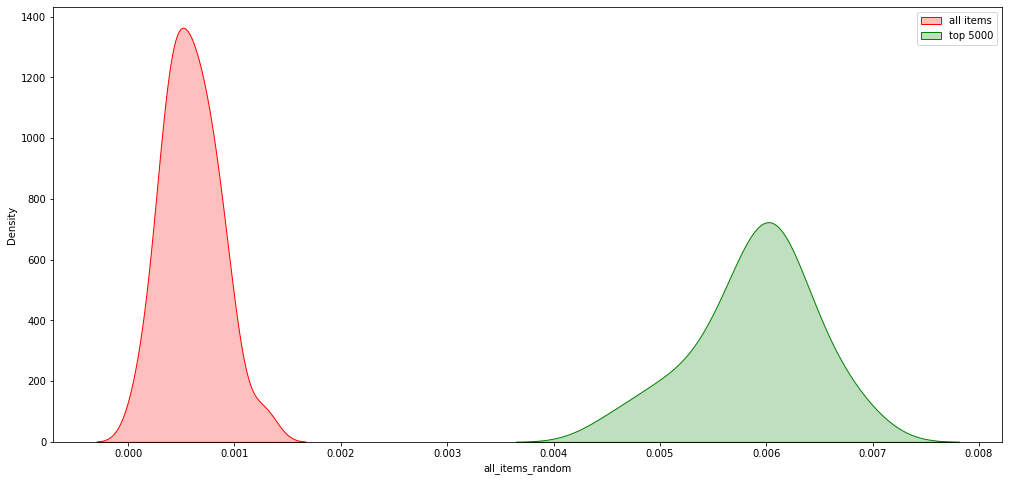

In [208]:
plt.figure(figsize=(17, 8))

sns.kdeplot(results_df['all_items_random'], shade=True, label='all items', color='r')
sns.kdeplot(results_df['top5000_random'], shade=True, label='top 5000', color='g')
plt.legend()

print(mannwhitneyu(results_df['all_items_random'], results_df['top5000_random']))

Различия показателей метрики при случайных рекомендациях на всех товарах и топ-5000 товаров являются статистически значимыми. Значение p-value ниже порогового. 

Для **случайных рекомендаций отклоняется нулевая гипотеза**.

MannwhitneyuResult(statistic=394.5, pvalue=0.20736603526916292)


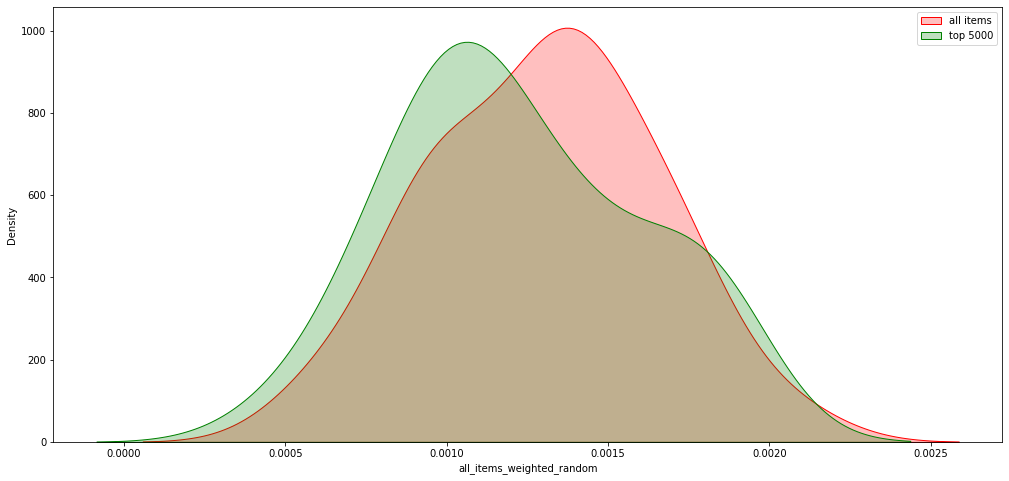

In [207]:
plt.figure(figsize=(17, 8))

sns.kdeplot(results_df['all_items_weighted_random'], shade=True, label='all items', color='r')
sns.kdeplot(results_df['top5000_weighted_random'], shade=True, label='top 5000', color='g')
plt.legend()

print(mannwhitneyu(results_df['all_items_weighted_random'], results_df['top5000_weighted_random']))

Различия показателей метрики при взвешенных случайных рекомендациях на всех товарах и топ-5000 товаров не являются статистически значимыми. Значение p-value выше порогового. 

Для **взвешенных случайных рекомендаций отклоняется альтернативная гипотеза**. 

### Вывод:

Случайные рекомендации на топ-5000 товарах, получаются более качественными в отличии от случайных рекомендаций на всех товарах. 

Метрики при взвешенных случайных рекомендациях на топ-5000 и всех товарах не имеют статистически значимых различий.